In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, when, length,udf
from pyspark.sql import functions as F
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import nltk
import string
!pip install nltk
import nltk
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
nltk.download('omw-1.4')
import spacy  # Ajout de spaCy pour le NER
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from pyspark.sql.types import *
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import Tokenizer
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.feature import HashingTF, IDF
from pyspark.ml.classification import LogisticRegression, NaiveBayes, GBTClassifier
from pyspark.mllib.classification import LogisticRegressionWithLBFGS, LogisticRegressionModel,LogisticRegressionWithSGD
from pyspark.mllib.regression import LabeledPoint
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import RegressionEvaluator, BinaryClassificationEvaluator
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.feature import NGram
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression as SklearnLogReg
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score,confusion_matrix
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from sklearn.manifold import TSNE
import matplotlib.cm as cm
import pandas as pd
from pyspark.ml.recommendation import ALS
import pickle
import os

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [2]:
# Charger le modèle spaCy pour le NER
nlp = spacy.load("en_core_web_sm")

In [3]:
my_spark=SparkSession.builder.appName("my_spark").getOrCreate()
print(my_spark)

In [4]:
chemin_local = "/content/dataset_projet_web_mining.csv"  #
df = my_spark.read.option("header", "true").csv(chemin_local)
df.show()


+--------------------+--------------------+----------+------+--------------------+--------------------+------------+--------------------+--------------------+--------------------+-------------------+-------------------+----------+------------------+--------------+--------------------+--------------------+--------------------+----------------+--------------------+----------------+
|                  id|                name|     asins| brand|          categories|                keys|manufacturer|        reviews.date|   reviews.dateAdded|    reviews.dateSeen|reviews.didPurchase|reviews.doRecommend|reviews.id|reviews.numHelpful|reviews.rating|  reviews.sourceURLs|        reviews.text|       reviews.title|reviews.userCity|reviews.userProvince|reviews.username|
+--------------------+--------------------+----------+------+--------------------+--------------------+------------+--------------------+--------------------+--------------------+-------------------+-------------------+----------+----

# Recommendation ALS

In [5]:
electro_ratings = df.select(
    col("id").alias("reviewerID"),
    col("asins").alias("ElectroID"),
    col("`reviews.rating`").alias("rating")
).dropna()

user_indexer = StringIndexer(inputCol="reviewerID", outputCol="userIndex")
electro_indexer = StringIndexer(inputCol="ElectroID", outputCol="ElectroIndex")
electro_ratings = user_indexer.fit(electro_ratings).transform(electro_ratings)
electro_ratings = electro_indexer.fit(electro_ratings).transform(electro_ratings)

electro_ratings = electro_ratings.select(
    col("userIndex").cast("int").alias("reviewerID"),
    col("ElectroIndex").cast("int").alias("ElectroID"),
    col("rating").cast("float")
)
electro_ratings.show()

+----------+---------+------+
|reviewerID|ElectroID|rating|
+----------+---------+------+
|         3|        3|   5.0|
|         3|        3|   5.0|
|         3|        3|   5.0|
|         3|        3|   4.0|
|         3|        3|   5.0|
|         3|        3|   5.0|
|         3|        3|   4.0|
|         3|        3|   5.0|
|         3|        3|   5.0|
|         3|        3|   5.0|
|         3|        3|   4.0|
|         3|        3|   5.0|
|         3|        3|   4.0|
|         3|        3|   5.0|
|         3|        3|   5.0|
|         3|        3|   5.0|
|         3|        3|   4.0|
|         3|        3|   4.0|
|         3|        3|   5.0|
|         3|        3|   5.0|
+----------+---------+------+
only showing top 20 rows



In [6]:
# Initialize ALS with parameters
als = ALS(userCol="reviewerID",
          itemCol="ElectroID",
          ratingCol="rating",
          nonnegative=True,
          coldStartStrategy="drop",
          implicitPrefs=False)

In [7]:
param_grid = ParamGridBuilder() \
                  .addGrid(als.rank, [5, 20]) \
                  .addGrid(als.maxIter, [5]) \
                  .addGrid(als.regParam, [0.01, 0.05, 1]) \
                  .build()

In [8]:
# Define evaluator
reg_eval = RegressionEvaluator(metricName = "rmse",
                               predictionCol = "prediction",
                               labelCol = "rating")
reg_eval_r2 = RegressionEvaluator(metricName="r2", predictionCol="prediction", labelCol="rating")


print(f"Num models to be tested: {len(param_grid)}")


Num models to be tested: 6


In [9]:
#Creating the crossValidation
cv = CrossValidator(estimator = als,
                    estimatorParamMaps= param_grid,
                    evaluator = reg_eval,
                    numFolds = 5)

In [10]:
# Split data into 80% train, 20% test
training_data, test_data = electro_ratings.randomSplit([0.8, 0.2], seed = 0)
# Remplacer les NaN par une valeur, par exemple 0
training_data = training_data.fillna({'rating': 0})

# Training model
model = cv.fit(training_data)

# Get best model
best_model = model.bestModel

In [11]:
import shutil
import os

# Affichage du type de modèle
print(type(best_model))

# Affichage des hyperparamètres du meilleur modèle
print("\n**Best Model**")
print("  Rank:", best_model.rank)
print("  MaxIter:", best_model._java_obj.parent().getMaxIter())
print("  RegParam:", best_model._java_obj.parent().getRegParam())

# Chemin de sauvegarde
model_path = "models/als_best_model"

import shutil
import os

# Affichage du type de modèle
print(type(best_model))

# Affichage des hyperparamètres du meilleur modèle
print("\n**Best Model**")
print("  Rank:", best_model.rank)
print("  MaxIter:", best_model._java_obj.parent().getMaxIter())
print("  RegParam:", best_model._java_obj.parent().getRegParam())

# Chemin de sauvegarde
model_path = "models/als_best_model"



<class 'pyspark.ml.recommendation.ALSModel'>

**Best Model**
  Rank: 20
  MaxIter: 5
  RegParam: 0.01
<class 'pyspark.ml.recommendation.ALSModel'>

**Best Model**
  Rank: 20
  MaxIter: 5
  RegParam: 0.01


In [12]:
# Supprimer l'ancien modèle s'il existe
if os.path.exists(model_path):
    shutil.rmtree(model_path)

# Sauvegarde du meilleur modèle
best_model.save(model_path)

# Compression du dossier (dans Colab)
!zip -r models/als_best_model.zip models/als_best_model

print("✅ Modèle sauvegardé et compressé avec succès.")


  adding: models/als_best_model/ (stored 0%)
  adding: models/als_best_model/itemFactors/ (stored 0%)
  adding: models/als_best_model/itemFactors/.part-00007-a03350f6-660b-43c0-bfb5-48a0f6bb947f-c000.snappy.parquet.crc (stored 0%)
  adding: models/als_best_model/itemFactors/part-00007-a03350f6-660b-43c0-bfb5-48a0f6bb947f-c000.snappy.parquet (deflated 22%)
  adding: models/als_best_model/itemFactors/part-00004-a03350f6-660b-43c0-bfb5-48a0f6bb947f-c000.snappy.parquet (deflated 27%)
  adding: models/als_best_model/itemFactors/part-00006-a03350f6-660b-43c0-bfb5-48a0f6bb947f-c000.snappy.parquet (deflated 22%)
  adding: models/als_best_model/itemFactors/part-00000-a03350f6-660b-43c0-bfb5-48a0f6bb947f-c000.snappy.parquet (deflated 23%)
  adding: models/als_best_model/itemFactors/part-00005-a03350f6-660b-43c0-bfb5-48a0f6bb947f-c000.snappy.parquet (deflated 26%)
  adding: models/als_best_model/itemFactors/.part-00000-a03350f6-660b-43c0-bfb5-48a0f6bb947f-c000.snappy.parquet.crc (stored 0%)
  add

In [13]:
# Predict ratings using trained model
predictions = best_model.transform(test_data)
predictions.show(5)

+----------+---------+------+----------+
|reviewerID|ElectroID|rating|prediction|
+----------+---------+------+----------+
|        28|       28|   3.0|  3.798224|
|        26|       27|   5.0|   4.99891|
|        12|       12|   2.0| 4.5700407|
|        12|       12|   3.0| 4.5700407|
|        12|       12|   3.0| 4.5700407|
+----------+---------+------+----------+
only showing top 5 rows



In [14]:
predictions_clean = predictions.filter(predictions['prediction'].isNotNull())
predictions_clean = predictions_clean.filter(predictions_clean['rating'].isNotNull())

In [15]:
# Evaluate the "test_predictions" dataframe
print("RMSE:", reg_eval.evaluate(predictions_clean))
print("R²:", reg_eval_r2.evaluate(predictions_clean))

RMSE: 0.728544019959848
R²: 0.036283775256842565


In [16]:
userRecs = best_model.recommendForAllUsers(5)
userRecs.show(5, truncate = False)

+----------+-----------------------------------------------------------------------------------+
|reviewerID|recommendations                                                                    |
+----------+-----------------------------------------------------------------------------------+
|20        |[{20, 4.71315}, {38, 2.545436}, {6, 2.3752308}, {16, 1.6649216}, {1, 1.5869889}]   |
|10        |[{10, 4.540842}, {27, 2.933754}, {12, 2.4695566}, {38, 2.4208758}, {8, 2.0956128}] |
|30        |[{29, 4.598249}, {31, 3.1046393}, {32, 2.9958832}, {1, 2.7333212}, {0, 2.648323}]  |
|0         |[{0, 4.454851}, {5, 3.876}, {31, 3.2322438}, {32, 3.1225562}, {3, 2.9578674}]      |
|31        |[{31, 4.9981775}, {32, 4.6437993}, {5, 3.7561312}, {0, 3.2811744}, {17, 3.2350206}]|
+----------+-----------------------------------------------------------------------------------+
only showing top 5 rows



In [17]:
userRecs_pandas = userRecs.toPandas()
userRecs_pandas.head()

,reviewerID,recommendations
0,20,"[(20, 4.7131500244140625), (38, 2.545435905456..."
1,10,"[(10, 4.540842056274414), (27, 2.9337539672851..."
2,30,"[(29, 4.5982489585876465), (31, 3.104639291763..."
3,0,"[(0, 4.454851150512695), (5, 3.875999927520752..."
4,31,"[(31, 4.998177528381348), (32, 4.6437993049621..."


In [18]:
def get_user_recommended_electro(recs_df, userId):
  try:
    recommendations = recs_df[recs_df["reviewerID"] == userId]["recommendations"]
    for electro in recommendations[0]:
      print(f"ElectroID: \n{electro[0]}\nPredicted Rating: {electro[1]}\n")
  except:
    print("That userId does not exist in the dataset.  Try another.")

In [19]:
get_user_recommended_electro(userRecs_pandas, 20)

ElectroID: 
20
Predicted Rating: 4.7131500244140625

ElectroID: 
38
Predicted Rating: 2.545435905456543

ElectroID: 
6
Predicted Rating: 2.3752307891845703

ElectroID: 
16
Predicted Rating: 1.6649216413497925

ElectroID: 
1
Predicted Rating: 1.586988925933838



###Entité Nommées


In [20]:
# Fonction de détection des entités nommées avec spaCy
def ner_udf(text):
    if text is not None:
        doc = nlp(text)
        # Extraction des entités nommées (noms de personnes, lieux, organisations, etc.)
        entities = [(ent.text, ent.label_) for ent in doc.ents]
        return str(entities)
    else:
        return None

# Créer une UDF PySpark pour appliquer la fonction de NER
udf_ner = udf(ner_udf, StringType())

# Appliquer la fonction NER à chaque avis dans le DataFrame PySpark
df = df.withColumn("named_entities", udf_ner(col("`reviews.text`")))

# Vérifier le résultat
df.select("`reviews.text`", "named_entities").show(10)

+--------------------+--------------------+
|        reviews.text|      named_entities|
+--------------------+--------------------+
|This product so f...|                  []|
|great for beginne...|                  []|
|Inexpensive table...|  [('Skype', 'ORG')]|
|I've had my Fire ...|[('two weeks', 'D...|
|I bought this for...|[('Amazon', 'ORG'...|
|This amazon fire ...|[('8 inch tablet'...|
|Great for e-readi...|                  []|
|I gave this as a ...|[('Christmas', 'D...|
|Great as a device...|                  []|
|I love ordering b...|                  []|
+--------------------+--------------------+
only showing top 10 rows



In [21]:
#Nombre de valeurs manquantes par colonnes
#df.select([
#    sum(when(col(f"`{c}`").isNull() | (col(f"`{c}`") == ""), 1).otherwise(0)).alias(c)
#    for c in df.columns
#]).show()

In [22]:
df = df.drop("reviews.id", "reviews.userCity", "reviews.userProvince")

In [23]:
print(df.columns)


['id', 'name', 'asins', 'brand', 'categories', 'keys', 'manufacturer', 'reviews.date', 'reviews.dateAdded', 'reviews.dateSeen', 'reviews.didPurchase', 'reviews.doRecommend', 'reviews.numHelpful', 'reviews.rating', 'reviews.sourceURLs', 'reviews.text', 'reviews.title', 'reviews.username', 'named_entities']


In [24]:
df.show()

+--------------------+--------------------+----------+------+--------------------+--------------------+------------+--------------------+--------------------+--------------------+-------------------+-------------------+------------------+--------------+--------------------+--------------------+--------------------+----------------+--------------------+
|                  id|                name|     asins| brand|          categories|                keys|manufacturer|        reviews.date|   reviews.dateAdded|    reviews.dateSeen|reviews.didPurchase|reviews.doRecommend|reviews.numHelpful|reviews.rating|  reviews.sourceURLs|        reviews.text|       reviews.title|reviews.username|      named_entities|
+--------------------+--------------------+----------+------+--------------------+--------------------+------------+--------------------+--------------------+--------------------+-------------------+-------------------+------------------+--------------+--------------------+----------------

In [25]:
# Fonction sentiment dans PySpark
def sentiment_udf(rating):
    if rating < 3:
        return "Negative"
    elif rating > 3:
        return "Positive"
    else:
        return "Neutral"

# Créer la colonne 'Sentiment' avec PySpark
df = df.withColumn("Sentiment",
                   F.when(F.col("`reviews.rating`") < 3, "Negative")
                    .when(F.col("`reviews.rating`") > 3, "Positive")
                    .otherwise("Neutral"))

In [26]:
# Afficher les 10 premières lignes pour vérifier
df.select("`reviews.rating`", "Sentiment").show(10)

+--------------+---------+
|reviews.rating|Sentiment|
+--------------+---------+
|             5| Positive|
|             5| Positive|
|             5| Positive|
|             4| Positive|
|             5| Positive|
|             5| Positive|
|             4| Positive|
|             5| Positive|
|             5| Positive|
|             5| Positive|
+--------------+---------+
only showing top 10 rows



In [27]:
df = df.withColumn("length", length("`reviews.text`"))


In [28]:
# Trouver la longueur maximale
max_length = df.agg({"length": "max"}).collect()[0][0]

# Récupérer l'avis le plus long
longest_review = df.filter(df["length"] == max_length).select("`reviews.text`").collect()[0][0]
print(longest_review)


This is a review of the Kindle Paperwhite launched July 2015. Essentially. the same as the previous Kindle Paperwhite but with a fantastic upgraded (300 dpi) screen, more memory and storage it's a terrific reading device. This review aims to describe both this product, and compare it with the other Kindle devices available to help you choose the best one for you.Before I start, Ive noticed several complains about Kindle not supporting the ePub format used by Canadian public libraries. Dont be put off, theres a solution in the Frequently Asked Questions section below.This review is broken up into sections so you can skip the less interesting bits. If youre in a hurry Ive included a summary at the start, and a Frequently Asked Questions section at the end.Summary - What can you do with it-----------------------------------------* Read a book. It can store 1,000s of books - take an entire library away with you on holiday.* Buy a book. You can browse the Amazon kindle store, and buy books 

In [29]:
# Trouver la longueur minimale
min_length = df.agg({"length": "min"}).collect()[0][0]

# Récupérer l'avis avec la longueur minimale
shortest_review = df.filter(df["length"] == min_length).select("`reviews.text`").collect()[0][0]
print(shortest_review)


5


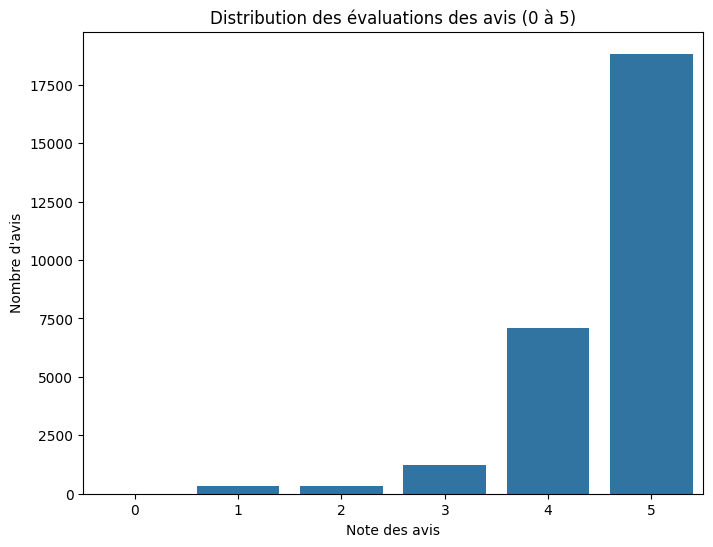

In [30]:
# Convertir le DataFrame PySpark en pandas DataFrame
pandas_df = df.toPandas()

# Tracer le countplot
plt.figure(figsize=(8, 6))
sns.countplot(x='reviews.rating', data=pandas_df, order=[0, 1, 2, 3, 4, 5])
plt.title("Distribution des évaluations des avis (0 à 5)")
plt.xlabel("Note des avis")
plt.ylabel("Nombre d'avis")
plt.show()

<ipython-input-31-855b2ff2a407>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Sentiment", data=pandas_df, palette=["#f8de7e", "#32fa53", "#fa3232"])


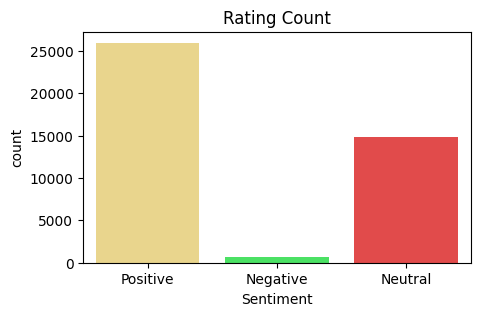

In [31]:
# créer le graphique
plt.figure(figsize=(5,3))
sns.countplot(x="Sentiment", data=pandas_df, palette=["#f8de7e", "#32fa53", "#fa3232"])
plt.title("Rating Count")
plt.show()

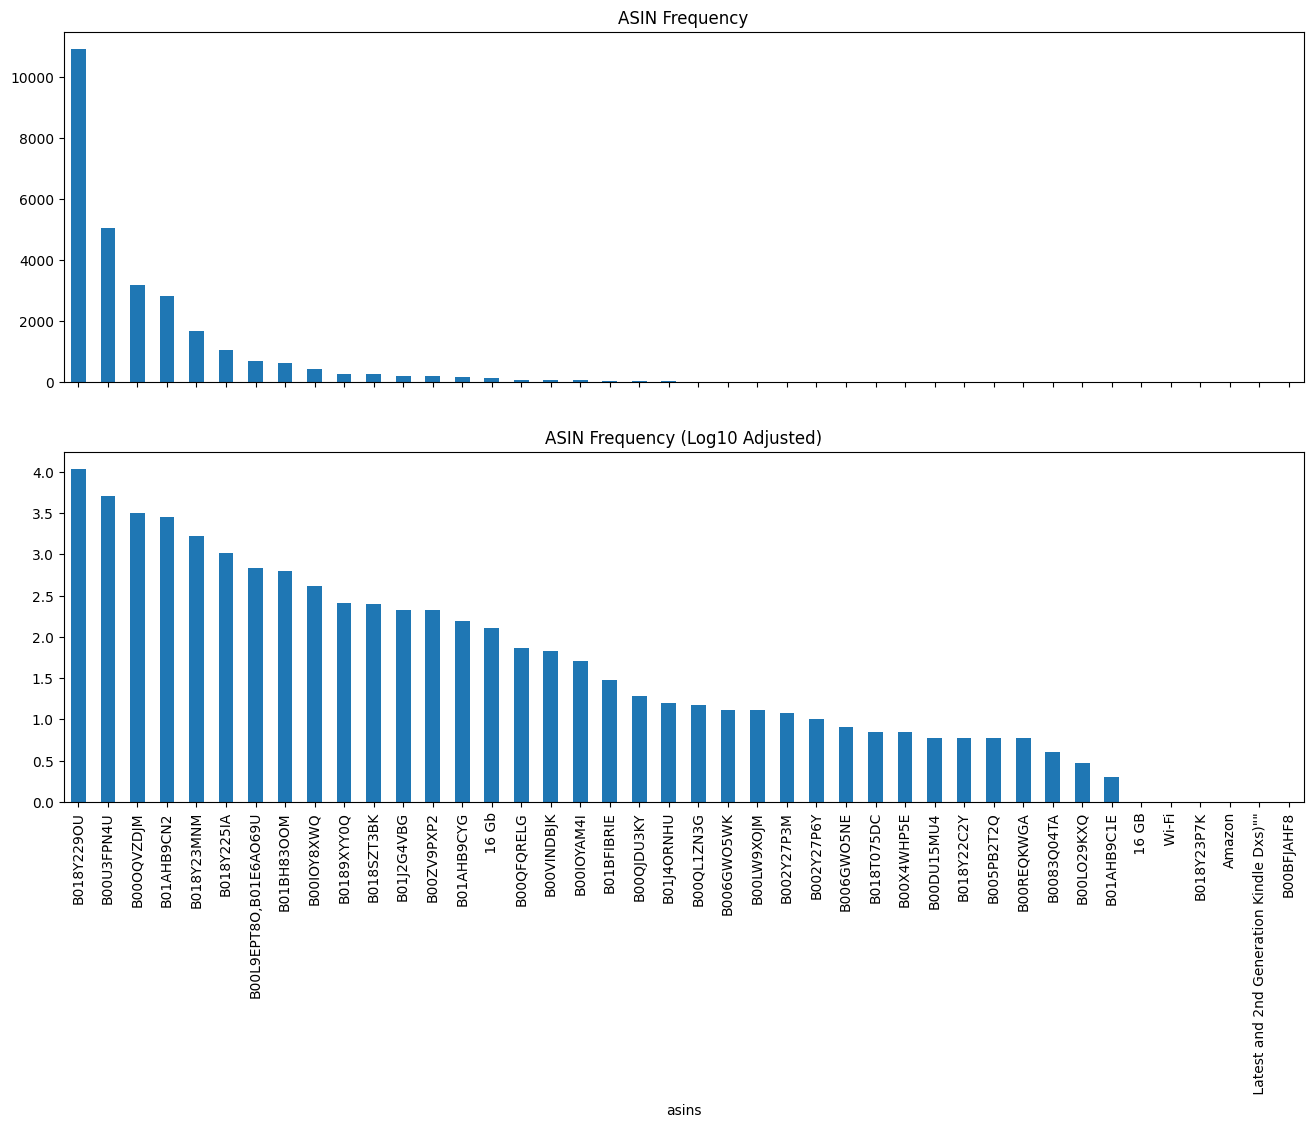

In [32]:
fig = plt.figure(figsize=(16,10))
ax1 = plt.subplot(211)
ax2 = plt.subplot(212, sharex = ax1)
pandas_df["asins"].value_counts().plot(kind="bar", ax=ax1, title="ASIN Frequency")
np.log10(pandas_df["asins"].value_counts()).plot(kind="bar", ax=ax2, title="ASIN Frequency (Log10 Adjusted)")
plt.show()

<Figure size 800x600 with 0 Axes>

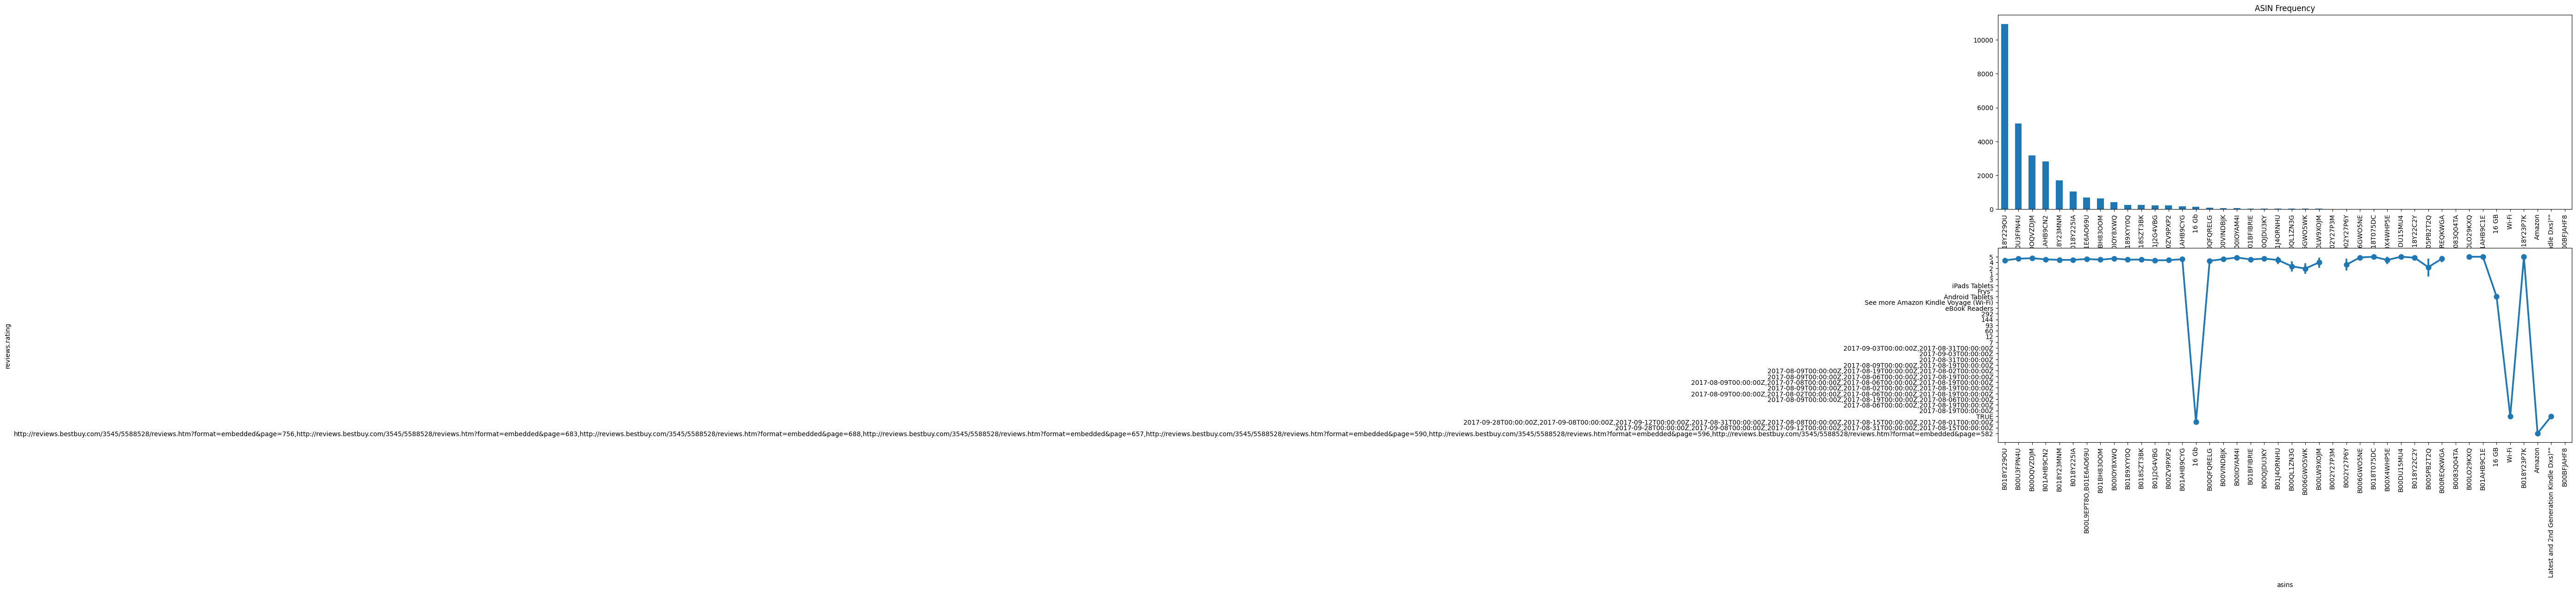

In [33]:
#reviews.rating / ASINs
plt.figure(figsize=(8, 6))
asins_count_ix = pandas_df["asins"].value_counts().index
plt.subplots(2,1,figsize=(16,12))
plt.subplot(2,1,1)
pandas_df["asins"].value_counts().plot(kind="bar", title="ASIN Frequency")
plt.subplot(2,1,2)
sns.pointplot(x="asins", y="reviews.rating", order=asins_count_ix, data=pandas_df)
plt.xticks(rotation=90)
plt.show()

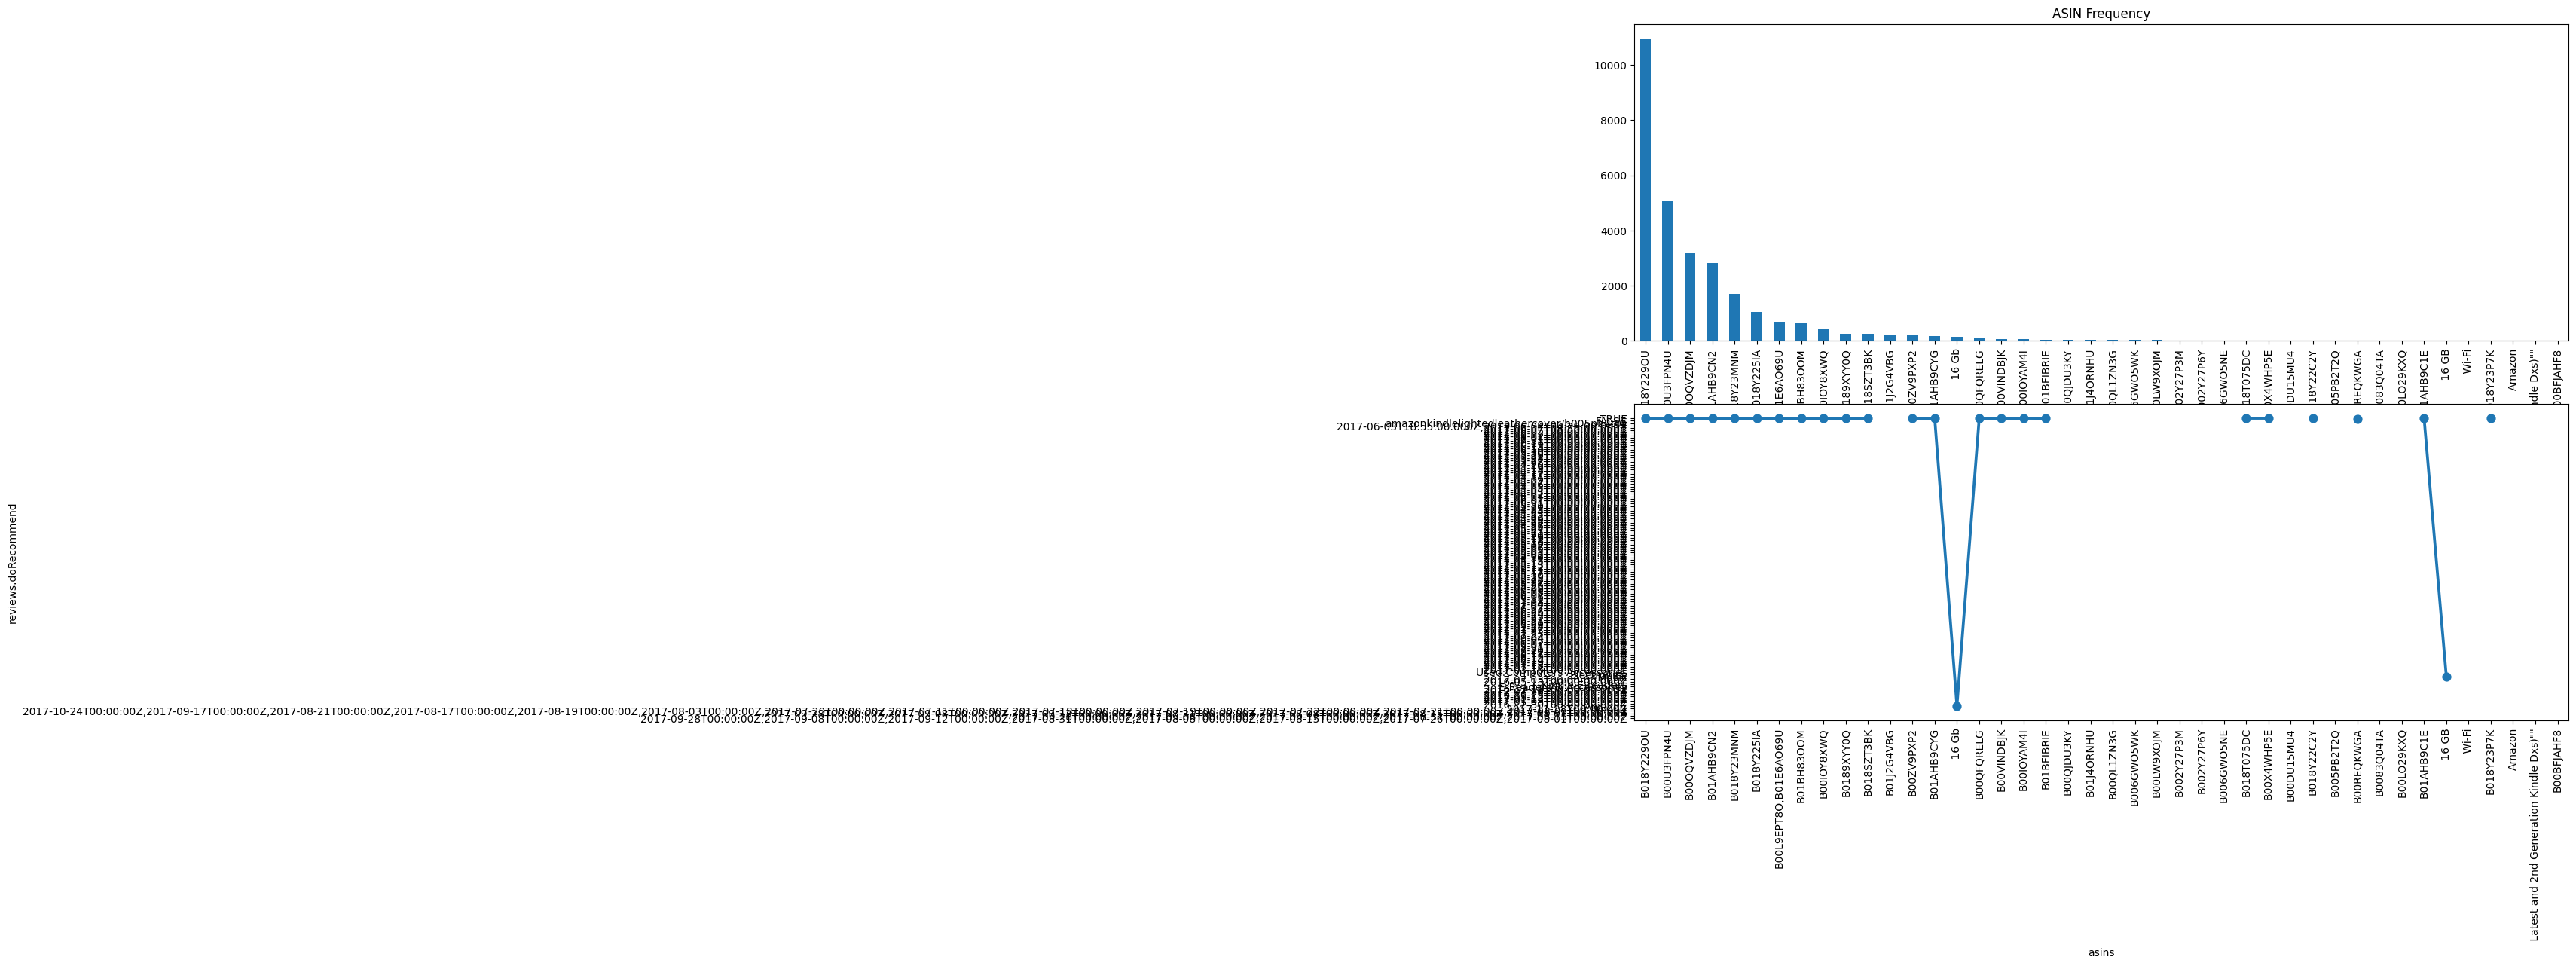

In [34]:
#reviews.doRecommend / ASINs
plt.subplots (2,1,figsize=(16,12))
plt.subplot(2,1,1)
pandas_df["asins"].value_counts().plot(kind="bar", title="ASIN Frequency")
plt.subplot(2,1,2)
sns.pointplot(x="asins", y="reviews.doRecommend", order=asins_count_ix, data=pandas_df)
plt.xticks(rotation=90)
plt.show()

In [35]:
# Convertir les étiquettes de texte en valeurs numériques
df1 = df.withColumn(
    "label",
    when(col("Sentiment") == "Positive", 1)
    .when(col("Sentiment") == "Negative", 0)
    .when(col("Sentiment") == "Neutral", 0)  # Vous pouvez aussi utiliser 0 pour  une classification binaire
    .otherwise(None)  # Valeurs manquantes
)

# Vérifier les modifications
df1.select("Sentiment", "label").show(10)

+---------+-----+
|Sentiment|label|
+---------+-----+
| Positive|    1|
| Positive|    1|
| Positive|    1|
| Positive|    1|
| Positive|    1|
| Positive|    1|
| Positive|    1|
| Positive|    1|
| Positive|    1|
| Positive|    1|
+---------+-----+
only showing top 10 rows



In [36]:
print(pandas_df.columns.tolist())

['id', 'name', 'asins', 'brand', 'categories', 'keys', 'manufacturer', 'reviews.date', 'reviews.dateAdded', 'reviews.dateSeen', 'reviews.didPurchase', 'reviews.doRecommend', 'reviews.numHelpful', 'reviews.rating', 'reviews.sourceURLs', 'reviews.text', 'reviews.title', 'reviews.username', 'named_entities', 'Sentiment', 'length']


### Prediction des sentiment avec Logistic Regression

In [37]:
# Supposons que pandas_df est déjà préparé avec 'review_text' et 'Sentiment'
pandas_df = pandas_df.dropna(subset=['reviews.text'])

# Encodage des labels
label_encoder = LabelEncoder()
pandas_df['Sentiment_encoded'] = label_encoder.fit_transform(pandas_df['Sentiment'])
cat = label_encoder.classes_

<ipython-input-37-8771130ca089>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pandas_df['Sentiment_encoded'] = label_encoder.fit_transform(pandas_df['Sentiment'])


In [38]:
# TF-IDF vectorisation
tfidf_m = TfidfVectorizer(max_features=5000)
X = tfidf_m.fit_transform(pandas_df['reviews.text'])
y = pandas_df['Sentiment_encoded']

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [39]:
# Entraînement modèle
lr_model = SklearnLogReg(max_iter=1000)
lr_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [40]:
# Sauvegarde des objets
import joblib
joblib.dump(lr_model, "lr_model.pkl")
joblib.dump(tfidf_m, "tfidf_vectorizer.pkl")
joblib.dump(label_encoder, "label_encoder.pkl")
print("Modèle et objets enregistrés.")

# Évaluation
y_pred = lr_model.predict(X_test)
report = classification_report(y_test, y_pred, target_names=cat)
print("\nRapport de classification sur les données de test :\n")
print(report)

Modèle et objets enregistrés.

Rapport de classification sur les données de test :

              precision    recall  f1-score   support

    Negative       0.72      0.13      0.23       217
     Neutral       0.92      0.86      0.89      2336
    Positive       0.94      0.98      0.96      7780

    accuracy                           0.94     10333
   macro avg       0.86      0.66      0.69     10333
weighted avg       0.93      0.94      0.93     10333



In [41]:
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='micro')
print(f"Accuracy: {acc:.3%}")
print(f"F1 score: {f1:.3f}")

# Fonction de prédiction
def predict_text(text):
    X_new = tfidf_m.transform([text])
    proba = lr_model.predict_proba(X_new)[0]
    return {cat[i]: proba[i] for i in range(len(cat))}

Accuracy: 93.632%
F1 score: 0.936


In [42]:
# Interaction utilisateur
while True:
    user_input = input("\nEntrez un texte à analyser (ou tapez 'exit' pour quitter) : ")
    if user_input.lower() == 'exit':
        break
    if user_input.strip() == "":
        print("Veuillez entrer un texte non vide.")
        continue
    prediction = predict_text(user_input)
    print("Résultat de la prédiction :")
    for label, prob in prediction.items():
        print(f"  {label} : {prob:.2%}")


Entrez un texte à analyser (ou tapez 'exit' pour quitter) : I’m really pleased with how this project turned out. The team collaborated effectively, met all the deadlines, and maintained clear communication throughout the process. Everyone brought their strengths to the table, which made a big difference in the final result. The client was very happy with the outcome, and it’s clear that our hard work paid off. I’m looking forward to working on more projects like this in the future.
Résultat de la prédiction :
  Negative : 3.55%
  Neutral : 5.88%
  Positive : 90.56%

Entrez un texte à analyser (ou tapez 'exit' pour quitter) : exit


### Prédiction des sentiments avec XGBoost

In [43]:
# Étape 3 : Encodage du label
label_encoder = LabelEncoder()
pandas_df['Sentiment_encoded'] = label_encoder.fit_transform(pandas_df['Sentiment'])
cat = label_encoder.classes_  # ex: ['Negative', 'Neutral', 'Positive']

# Étape 4 : Vectorisation TF-IDF
tfidf_m = TfidfVectorizer(max_features=5000)
X = tfidf_m.fit_transform(pandas_df['reviews.text'])
y = pandas_df['Sentiment_encoded']
# Étape 5 : Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [44]:
# --- Décalage labels (XGBoost attend labels 0-indexés) ---
y_train_shifted = y_train - 0  # déjà 0-indexé mais par sécurité
y_test_shifted = y_test - 0

# Étape 6 : Préparation DMatrix pour XGBoost
train_set = xgb.DMatrix(X_train, label=y_train)
test_set = xgb.DMatrix(X_test, label=y_test)

In [45]:
# Étape 7 : Paramètres et entraînement du modèle
parameters = {
    "max_depth": 6,
    "eta": 0.3,
    "objective": "multi:softprob",
    "num_class": len(cat),
    "verbosity": 0,
    "eval_metric": "mlogloss"
}

boost = xgb.train(parameters, train_set, num_boost_round=100)

In [46]:
# Évaluation du modèle
y_test_pred_proba = boost.predict(test_set)
y_test_pred = y_test_pred_proba.argmax(axis=1)

print("Classification Report :\n")
print(classification_report(y_test, y_test_pred, target_names=cat))



Classification Report :

              precision    recall  f1-score   support

    Negative       0.67      0.16      0.25       217
     Neutral       0.95      0.85      0.90      2336
    Positive       0.94      0.99      0.96      7780

    accuracy                           0.94     10333
   macro avg       0.85      0.66      0.70     10333
weighted avg       0.93      0.94      0.93     10333



In [47]:
acc = accuracy_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred, average='micro')
print(f"Accuracy: {acc:.3%}")
print(f"F1 score: {f1:.3f}")

Accuracy: 93.777%
F1 score: 0.938


In [48]:
#  Prédiction sur un texte
def predict_text(text):
    X_new = tfidf_m.transform([text])
    dmatrix_new = xgb.DMatrix(X_new)
    proba = boost.predict(dmatrix_new)[0]
    return {cat[i]: proba[i] for i in range(len(cat))}


In [49]:
# --- Interaction simple pour prédiction ---
while True:
    user_input = input("\nEntrez un texte à analyser (ou tapez 'exit' pour quitter) : ")
    if user_input.lower() == 'exit':
        break
    if user_input.strip() == "":
        print("Veuillez entrer un texte non vide.")
        continue
    prediction = predict_text(user_input)
    print("Résultat de la prédiction :")
    for label, prob in prediction.items():
        print(f"  {label} : {prob:.2%}")


Entrez un texte à analyser (ou tapez 'exit' pour quitter) : I’m really pleased with how this project turned out. The team collaborated effectively, met all the deadlines, and maintained clear communication throughout the process. Everyone brought their strengths to the table, which made a big difference in the final result. The client was very happy with the outcome, and it’s clear that our hard work paid off. I’m looking forward to working on more projects like this in the future.
Résultat de la prédiction :
  Negative : 4.47%
  Neutral : 3.27%
  Positive : 92.26%

Entrez un texte à analyser (ou tapez 'exit' pour quitter) : exit


In [50]:
# Étape 10 : Sauvegarde du modèle
boost.save_model("xgboost_sentiment_model.json")
joblib.dump(tfidf_m, "tfidf_vectorizer.joblib")
joblib.dump(label_encoder, "label_encoder.joblib")

['label_encoder.joblib']

### Prédiction des sentiments avec SVM

In [51]:
from sklearn.svm import LinearSVC
label_encoder = LabelEncoder()
pandas_df['Sentiment_encoded'] = label_encoder.fit_transform(pandas_df['Sentiment'])
cat = label_encoder.classes_  # ex: ['Negative', 'Neutral', 'Positive']

# Étape 4 : Vectorisation TF-IDF
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(pandas_df['reviews.text'])
y = pandas_df['Sentiment_encoded']
# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [52]:
# Chemins des fichiers à sauvegarder
model_path = "svm_model.pkl"
vectorizer_path = "tfidf_vectorizer_svm.pkl"
label_encoder_path = "label_encoder_svm.pkl"

In [53]:

# Entraînement du modèle
svm = LinearSVC()
svm.fit(X_train, y_train)

LinearSVC()

In [54]:
y_pred = svm.predict(X_test)
report = classification_report(y_test, y_pred, target_names=cat)
print("\n📈 Rapport de classification :")
print(report)


📈 Rapport de classification :
              precision    recall  f1-score   support

    Negative       0.54      0.21      0.30       217
     Neutral       0.89      0.87      0.88      2336
    Positive       0.95      0.97      0.96      7780

    accuracy                           0.93     10333
   macro avg       0.79      0.68      0.71     10333
weighted avg       0.93      0.93      0.93     10333



In [55]:
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='micro')
print(f"Accuracy: {acc:.3%}")
print(f"F1 score: {f1:.3f}")

Accuracy: 93.274%
F1 score: 0.933


In [56]:
from sklearn.calibration import CalibratedClassifierCV

# Après entraînement du svm :
svm_calibrated = CalibratedClassifierCV(svm)  # par défaut méthode 'sigmoid'
svm_calibrated.fit(X_train, y_train)

# Sauvegarder svm_calibrated au lieu de svm
# Sauvegarde des objets
joblib.dump(svm_calibrated, model_path)
joblib.dump(tfidf, vectorizer_path)
joblib.dump(label_encoder, label_encoder_path)
print("💾 Modèles sauvegardés.")

def predict_text(text):
    X_new = tfidf.transform([text])
    proba = svm_calibrated.predict_proba(X_new)[0]  # tableau des probabilités
    return {cat[i]: proba[i] for i in range(len(cat))}


💾 Modèles sauvegardés.


In [57]:
# --- Interaction simple pour prédiction ---
while True:
    user_input = input("\nEntrez un texte à analyser (ou tapez 'exit' pour quitter) : ")
    if user_input.lower() == 'exit':
        break
    if user_input.strip() == "":
        print("Veuillez entrer un texte non vide.")
        continue
    prediction = predict_text(user_input)
    print("Résultat de la prédiction :")
    for label, prob in prediction.items():
        print(f"  {label} : {prob:.2%}")


Entrez un texte à analyser (ou tapez 'exit' pour quitter) : I’m really pleased with how this project turned out. The team collaborated effectively, met all the deadlines, and maintained clear communication throughout the process. Everyone brought their strengths to the table, which made a big difference in the final result. The client was very happy with the outcome, and it’s clear that our hard work paid off. I’m looking forward to working on more projects like this in the future.
Résultat de la prédiction :
  Negative : 0.94%
  Neutral : 17.10%
  Positive : 81.96%

Entrez un texte à analyser (ou tapez 'exit' pour quitter) : exit


### Lemmatization, Stemming, RemoveStopWords

In [58]:
# Définir la fonction pour transformer le texte en minuscules
def lower_text(line):
    if line is not None:
        return line.lower()
    else:
        return None
# Créer une UDF à partir de la fonction
udflower_text = udf(lower_text, StringType())

# Vérifier les colonnes disponibles dans le DataFrame
df1.columns
#Lemmatization
def lemmatize_text(text):
    if text is None:
        return ""
    lmtzr = WordNetLemmatizer()
    words = text.split()
    tagged_words = pos_tag(words)
    lemmatized = []
    for word, tag in tagged_words:
        pos = 'v' if tag.lower().startswith('v') else 'n'
        lemma = lmtzr.lemmatize(word, pos)
        lemmatized.append(lemma)
    return ' '.join(lemmatized)

lemmatize_udf = udf(lemmatize_text, StringType())


# Appliquer la transformation avec la colonne correcte
df1 = df1.withColumn("text_lower", udflower_text(df["`reviews.text`"]))
# Remplacer les valeurs nulles par une chaîne vide dans la colonne 'text_lower'
df1 = df1.withColumn("text_lower", when(col("text_lower").isNull(), "").otherwise(col("text_lower")))
df1 = df1.withColumn("lemmatized_text", lemmatize_udf(col("text_lower")))


# Vérifier le résultat
messages_lower = df1.select('text_lower','lemmatized_text', 'label')
messages_lower.show(10)

+--------------------+--------------------+-----+
|          text_lower|     lemmatized_text|label|
+--------------------+--------------------+-----+
|this product so f...|this product so f...|    1|
|great for beginne...|great for beginne...|    1|
|inexpensive table...|inexpensive table...|    1|
|i've had my fire ...|i've have my fire...|    1|
|i bought this for...|i buy this for my...|    1|
|this amazon fire ...|this amazon fire ...|    1|
|great for e-readi...|great for e-readi...|    1|
|i gave this as a ...|i give this a a c...|    1|
|great as a device...|great a a device ...|    1|
|i love ordering b...|i love order book...|    1|
+--------------------+--------------------+-----+
only showing top 10 rows



In [59]:
# Appliquer la tokenisation sur la colonne 'text_lower'
tokenizer = Tokenizer(inputCol="text_lower", outputCol="words")
wordsDataFrame = tokenizer.transform(messages_lower)

# Afficher les premiers exemples après la tokenisation
for words_label in wordsDataFrame.select("words", "label").take(10):
    print(words_label)

Row(words=['this', 'product', 'so', 'far', 'has', 'not', 'disappointed.', 'my', 'children', 'love', 'to', 'use', 'it', 'and', 'i', 'like', 'the', 'ability', 'to', 'monitor', 'control', 'what', 'content', 'they', 'see', 'with', 'ease.'], label=1)
Row(words=['great', 'for', 'beginner', 'or', 'experienced', 'person.', 'bought', 'as', 'a', 'gift', 'and', 'she', 'loves', 'it'], label=1)
Row(words=['inexpensive', 'tablet', 'for', 'him', 'to', 'use', 'and', 'learn', 'on,', 'step', 'up', 'from', 'the', 'nabi.', 'he', 'was', 'thrilled', 'with', 'it,', 'learn', 'how', 'to', 'skype', 'on', 'it', 'already...'], label=1)
Row(words=["i've", 'had', 'my', 'fire', 'hd', '8', 'two', 'weeks', 'now', 'and', 'i', 'love', 'it.', 'this', 'tablet', 'is', 'a', 'great', 'value.we', 'are', 'prime', 'members', 'and', 'that', 'is', 'where', 'this', 'tablet', 'shines.', 'i', 'love', 'being', 'able', 'to', 'easily', 'access', 'all', 'of', 'the', 'prime', 'content', 'as', 'well', 'as', 'movies', 'you', 'can', 'downlo

In [60]:
# Removing stopwords
remover = StopWordsRemover(inputCol="words", outputCol="words_filtered")
wordsDataFrame1 = remover.transform(wordsDataFrame).select("label","words_filtered")

In [61]:
#Displaying the resultant dataframe
wordsDataFrame1.show(10)

+-----+--------------------+
|label|      words_filtered|
+-----+--------------------+
|    1|[product, far, di...|
|    1|[great, beginner,...|
|    1|[inexpensive, tab...|
|    1|[fire, hd, 8, two...|
|    1|[bought, grand, d...|
|    1|[amazon, fire, 8,...|
|    1|[great, e-reading...|
|    1|[gave, christmas,...|
|    1|[great, device, r...|
|    1|[love, ordering, ...|
+-----+--------------------+
only showing top 10 rows



In [62]:
# Stemming the text
stemmer = PorterStemmer()
def stem_tokens(tokens):
    return [stemmer.stem(item) for item in tokens]

In [63]:
def stem_text(tokens):
    stems = stem_tokens(tokens)
    return ' '.join(stems)

udfstem_text=udf(stem_text, StringType())
wordsDataFrame2 = wordsDataFrame1.withColumn("final_text", udfstem_text("words_filtered")).select('final_text','label')

In [64]:
# Caching the RDD
wordsDataFrame2.cache()
#Renaming features for modeling
training = wordsDataFrame2.selectExpr("final_text as text", "label as label")
training = training.withColumn("label", training["label"].cast(DoubleType()))
training.take(5)

[Row(text='product far disappointed. children love use like abil monitor control content see ease.', label=1.0),
 Row(text='great beginn experienc person. bought gift love', label=1.0),
 Row(text='inexpens tablet use learn on, step nabi. thrill it, learn skype already...', label=1.0),
 Row(text='fire hd 8 two week love it. tablet great value.w prime member tablet shines. love abl easili access prime content well movi download watch laterthi 1280/800 screen realli nice look nice crisp bright infact brighter ipad pro cost $900 base model. build fire insan awesom run 7.7mm thick smooth glossi feel back realli amaz hold like futurist tab ur hands.', label=1.0),
 Row(text='bought grand daughter come visit. set user, enter age name amazon make sure access site content appropri age. simpl love capabilities. also bought instal 64gig sd card give littl tablet plenti storage. price think tablet best one there. spend hundr dollar addit speed capac come basic tablet everyth peopl ever need fractio

# TF - IDF Pilpeling

In [65]:
#Creating pipeline for Tokenizing, TF - IDF and Logistic Regression Model
tokenizer = Tokenizer(inputCol="text", outputCol="words")
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="hashing")
idf = IDF(inputCol=hashingTF.getOutputCol(), outputCol="features")
lr = LogisticRegression(maxIter=10, regParam=0.01)
pipeline = Pipeline(stages=[tokenizer, hashingTF, idf, lr])
# Training the model
model = pipeline.fit(training)

In [66]:
#Predicing Output
prediction = model.transform(training)

In [67]:
#Printing Schema of Prediction Dataset
prediction.printSchema()

root
 |-- text: string (nullable = true)
 |-- label: double (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- hashing: vector (nullable = true)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [68]:
# ÉVALUATION
# ==========================
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="label")
auc = evaluator.evaluate(prediction, {evaluator.metricName: "areaUnderROC"})
print(f"AUC: {auc:.3f}")

AUC: 0.998


In [69]:
#Printing Error Rate on Training set :-
print ("Error rate is: {0}".format(prediction.rdd.map(lambda line: abs(line[1] - line[7])).reduce(lambda x,y:x+y) / float(prediction.count())))


Error rate is: 0.010598488689312185


# Word Cloud

In [70]:
wordclouddata = wordsDataFrame2.rdd.map(lambda x: (x[1],x[0])).flatMapValues(lambda x: x.split(' ')).flatMapValues(lambda x: x.split('.')).toDF()
wordclouddata = wordclouddata.selectExpr("_1 as Label","_2 as word")
wordclouddata.registerTempTable("words")

/usr/local/lib/python3.11/dist-packages/pyspark/sql/dataframe.py:329: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


/usr/local/lib/python3.11/dist-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


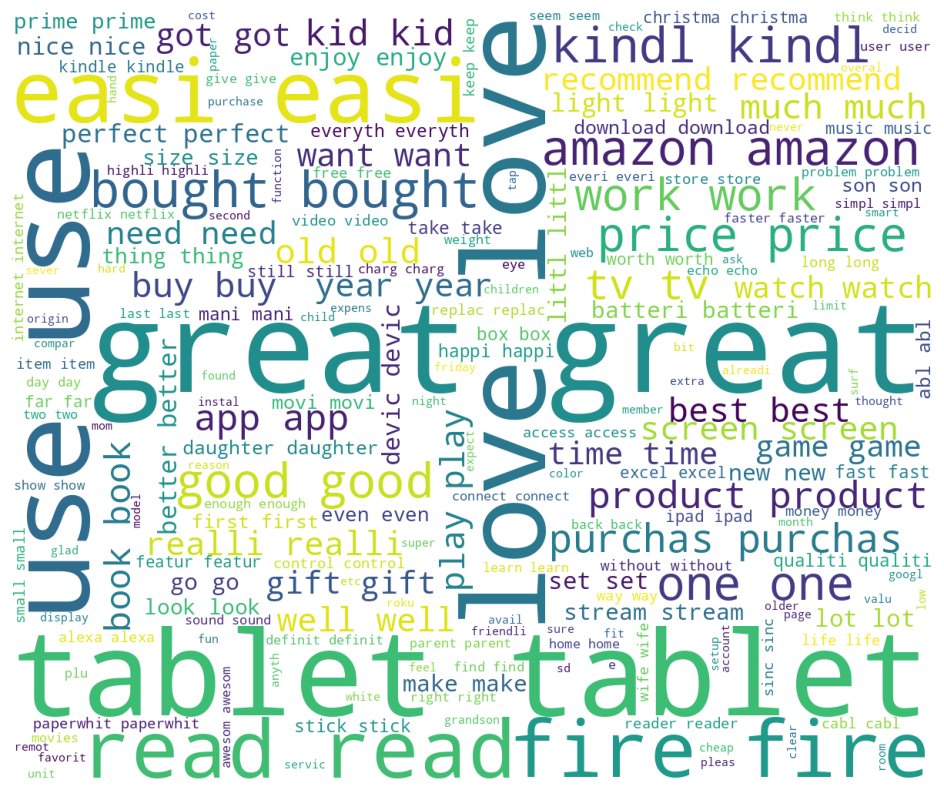

In [71]:
from pyspark.sql import SQLContext

# Create an SQLContext instance
sqlContext = SQLContext(my_spark)

# Now run your query
pos_words = sqlContext.sql("SELECT word, round(count(Label) / 100) as cnt FROM words WHERE Label = 1 GROUP BY word ORDER BY cnt DESC").take(1000)
x = ""
for i in pos_words:
        if (i[0] == "<br") | (i[0] == "/><br"):
            pass
        else:
            for a in range(int(i[1])):
                if i[0] == "":
                    pass
                else:
                    x = x +" " +  i[0]

plt.rcParams['figure.figsize'] = (20.0, 10.0)
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white',
                          width=1200,
                          height=1000
                         ).generate(x)


plt.imshow(wordcloud)
plt.axis('off')
plt.show()

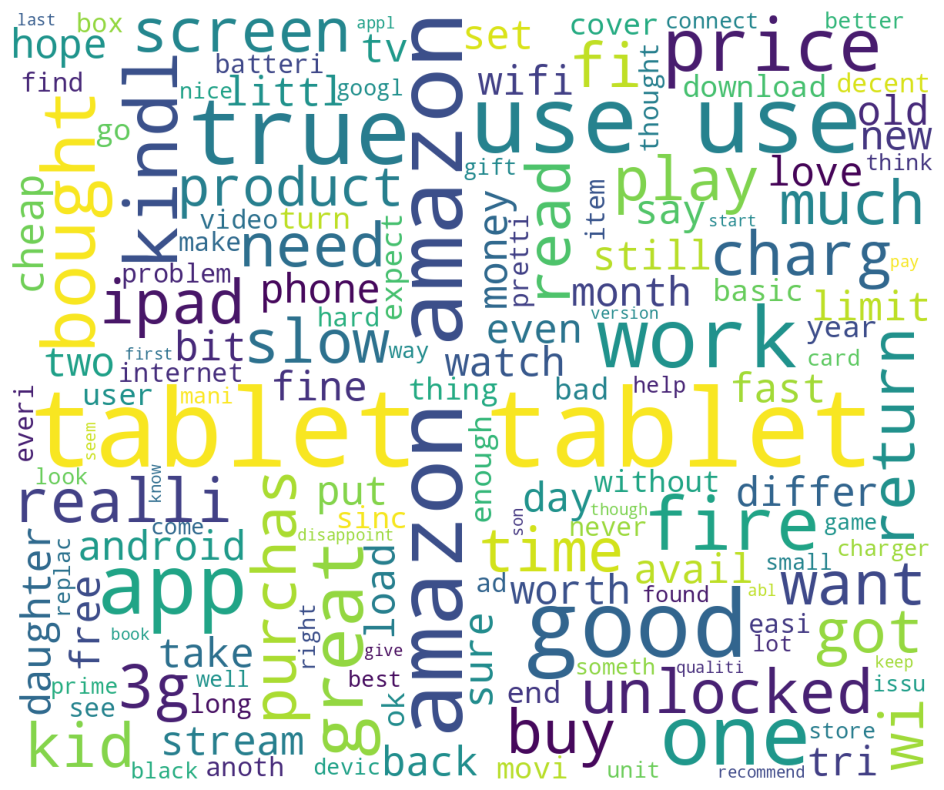

In [72]:
neg_words = sqlContext.sql(" SELECT word,round(count(Label) / 100) as cnt from words where Label = 0 group by word order by cnt desc").take(1000)

x = ""
for i in neg_words:
        if (i[0] == "<br") | (i[0] == "/><br"):
            pass
        else:
            for a in range(int(i[1])):
                if i[0] == "":
                    pass
                else:
                    x = x +" " +  i[0]

plt.rcParams['figure.figsize'] = (20.0, 10.0)
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white',
                          width=1200,
                          height=1000
                         ).generate(x)


plt.imshow(wordcloud)
plt.axis('off')
plt.show()


# Bi gram

In [73]:
wordsDataFrame_1 = wordsDataFrame1.filter(wordsDataFrame1.label == 1)
wordsDataFrame_0 = wordsDataFrame1.filter(wordsDataFrame1.label == 0)

In [74]:
wordsDataFrame_1.take(2)

[Row(label=1, words_filtered=['product', 'far', 'disappointed.', 'children', 'love', 'use', 'like', 'ability', 'monitor', 'control', 'content', 'see', 'ease.']),
 Row(label=1, words_filtered=['great', 'beginner', 'experienced', 'person.', 'bought', 'gift', 'loves'])]

In [75]:
ngram = NGram(n=2, inputCol="words_filtered", outputCol="nGrams")
ngram.transform(wordsDataFrame_1).head()

bigrammed = ngram.transform(wordsDataFrame_1)

In [76]:
bigrams = bigrammed.rdd.map(lambda line:line[2])
bigrams.take(2)

[['product far',
  'far disappointed.',
  'disappointed. children',
  'children love',
  'love use',
  'use like',
  'like ability',
  'ability monitor',
  'monitor control',
  'control content',
  'content see',
  'see ease.'],
 ['great beginner',
  'beginner experienced',
  'experienced person.',
  'person. bought',
  'bought gift',
  'gift loves']]

In [77]:
all_bigrams = bigrams.flatMap(lambda list:[x for x in list])
top1000_bigrams_1 = all_bigrams.map(lambda x:(x,1)).reduceByKey(lambda x,y:x+y).takeOrdered(1000, key=lambda x: -x[1])
bigrammed_0 = ngram.transform(wordsDataFrame_0)
bigrams_0 = bigrammed_0.rdd.map(lambda line:line[2])
all_bigrams_0 = bigrams_0.flatMap(lambda list:[x for x in list])
top1000_bigrams_0 = all_bigrams_0.map(lambda x:(x,1)).reduceByKey(lambda x,y:x+y).takeOrdered(1000, key=lambda x: -x[1])

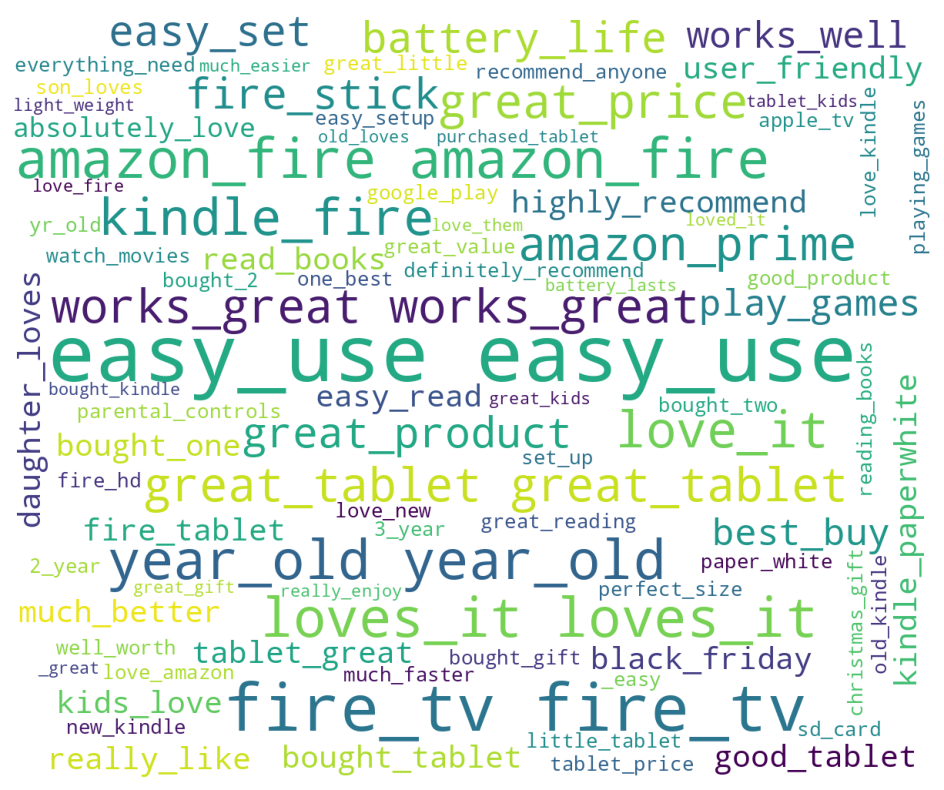

In [78]:
sc = my_spark.sparkContext
x1 = sc.parallelize(top1000_bigrams_1)

x2 = x1.map(lambda x:(x[0].replace(' ','_'), x[1]))
wordcloud_1 = x2.toDF()
wordcloud_1 = wordcloud_1.selectExpr("_1 as BiGram","_2 as freq")
wordcloud_1.registerTempTable("positive")


pos_words = sqlContext.sql(" SELECT BiGram, round(freq)/100 as cnt from positive where BiGram NOT LIKE '%/><br%' OR BiGram NOT LIKE '_%' OR BiGram NOT LIKE '%_' order by cnt desc")
pos_words1 = pos_words.collect()
x = ""
for i in pos_words1:
    if i[0][0] == "_":
        pass
    elif i[0][len(i[0])-1] == "_":
        pass
    else:
        for a in range(int(i[1])):
            x = x + " " +  str(i[0])

plt.rcParams['figure.figsize'] = (20.0, 10.0)
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white',
                          width=1200,
                          height=1000
                         ).generate(x)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

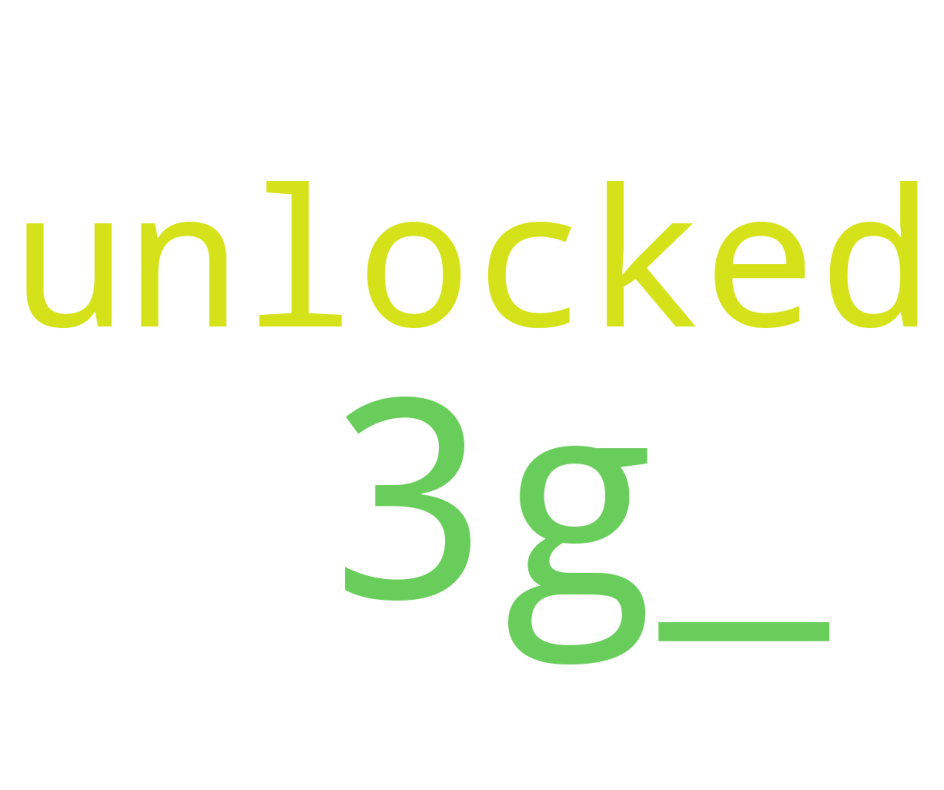

In [79]:
x1 = sc.parallelize(top1000_bigrams_0)
x2 = x1.map(lambda x:(x[0].replace(' ','_'), x[1]))
wordcloud_0 = x2.toDF()
wordcloud_0 = wordcloud_0.selectExpr("_1 as BiGram","_2 as freq")
wordcloud_0.registerTempTable("negative")


neg_words = sqlContext.sql(" SELECT BiGram, round(freq)/100 as cnt from negative where BiGram NOT LIKE '%/><br%' OR BiGram NOT LIKE '_%' OR BiGram NOT LIKE '%_' order by cnt desc")
neg_words0 = neg_words.collect()
y = ""
for i in neg_words0:
    if i[0][0] == "_":
        pass
    elif i[0][len(i[0])-1] == "_":
        pass
    else:
        for a in range(int(i[1])):
            y = y + " " +  str(i[0])

plt.rcParams['figure.figsize'] = (20.0, 10.0)
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white',
                          width=1200,
                          height=1000
                         ).generate(y)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()


Top 15 stemmed words per topic in LDA model

Topic #0:
tv, amazon, stick, alexa, music, love, 4k, movies, watch, shows, apple, paperwhite, best, did, bought
Topic #1:
games, tablet, play, son, bought, great, user, friendly, loved, use, video, loves, playing, lots, fun
Topic #2:
streaming, charger, internet, download, reader, room, web, charge, books, cable, favorite, library, media, wi, fi
Topic #3:
kindle, read, reading, books, love, light, like, screen, just, thing, book, remote, really, enjoy, size
Topic #4:
box, quality, echo, better, excellent, money, voice, awesome, say, value, version, options, different, pay, turn
Topic #5:
easy, use, great, love, kids, set, prime, amazon, tablet, works, product, family, apps, netflix, setup
Topic #6:
device, cable, small, home, used, ipad, using, things, getting, wifi, work, phone, speaker, tap, especially
Topic #7:
tablet, amazon, apps, good, battery, little, don, like, lot, great, just, life, want, store, does
Topic #8:
bought, old, loves, y

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


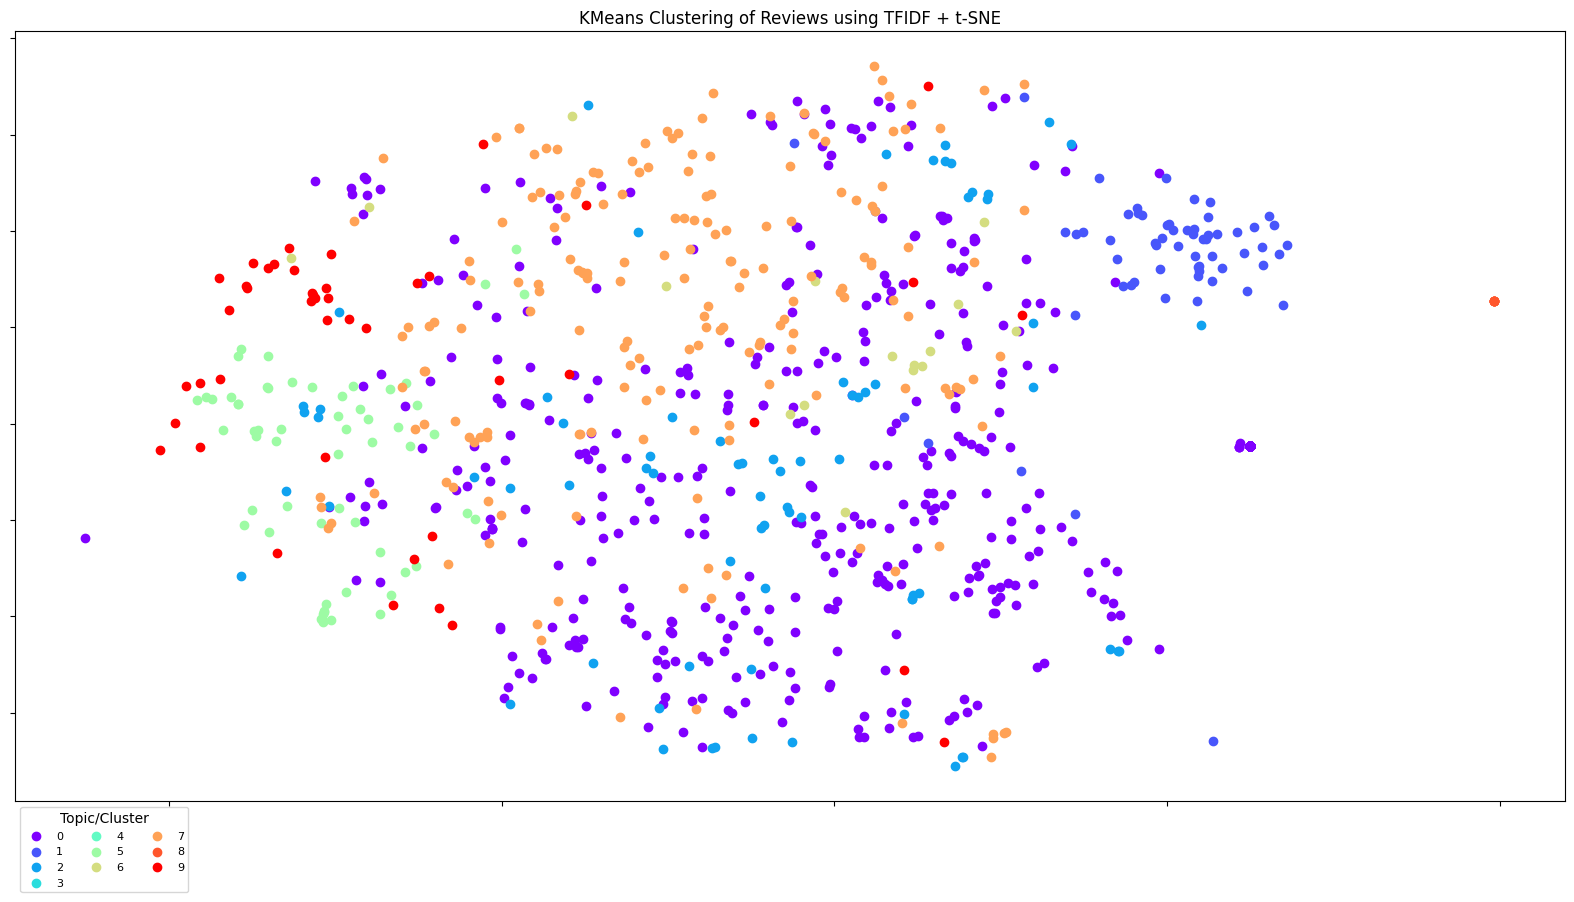

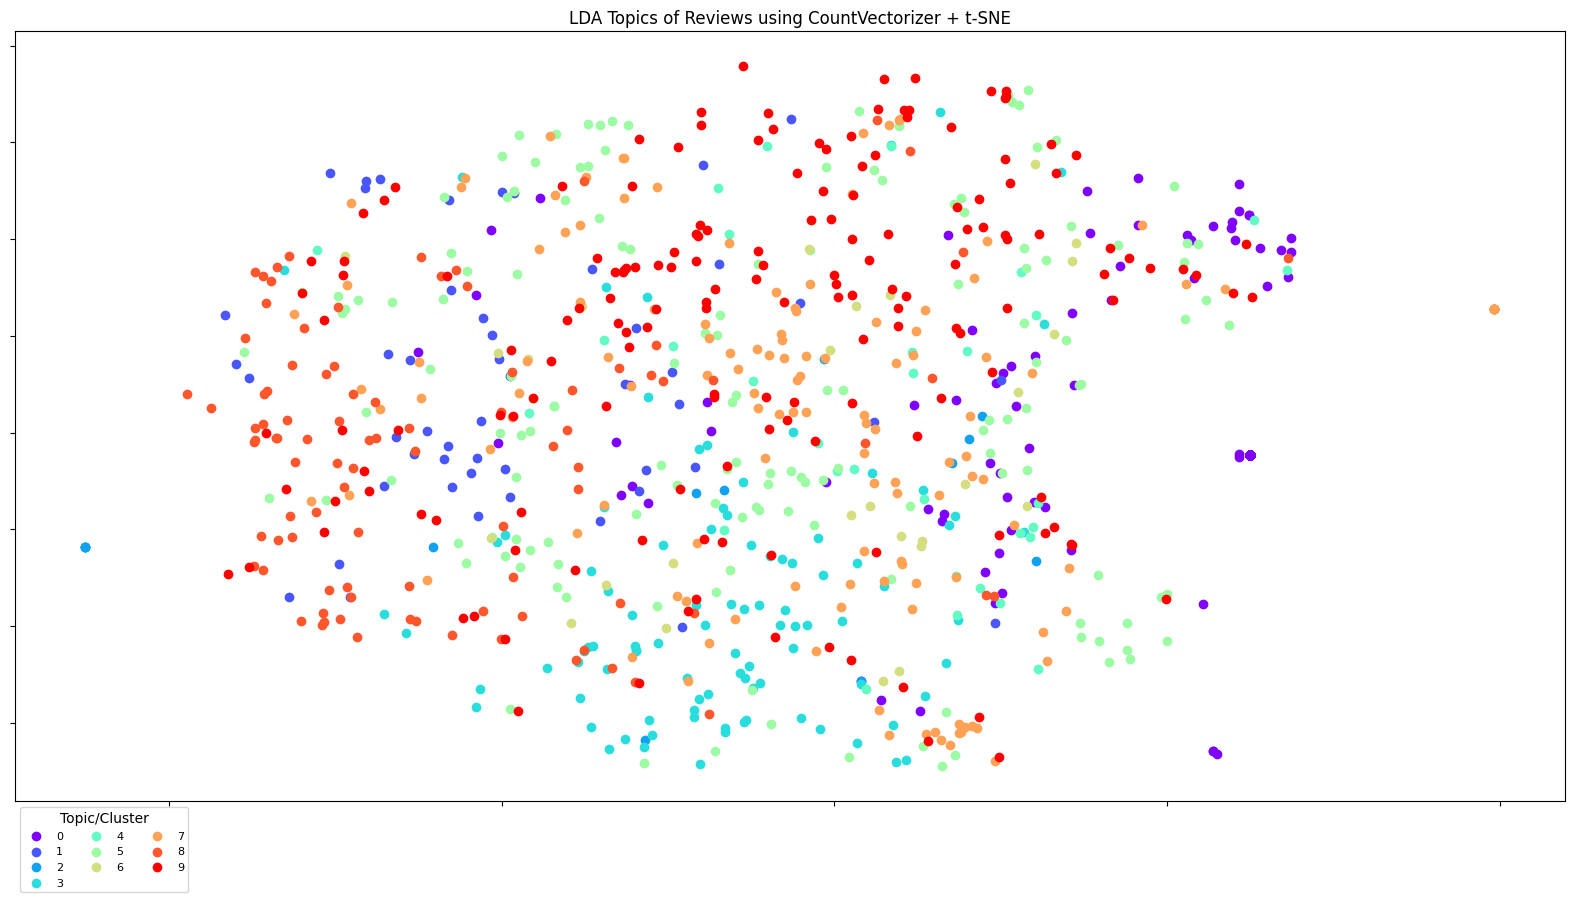

In [80]:
# Texte prétraité depuis le dataframe pandas_df
texts = pandas_df['reviews.text'].fillna("").values.astype("U")

# Vectorisation TF et TF-IDF
cv = CountVectorizer(max_df=0.9, min_df=5, stop_words='english')
tf_m = cv.fit(texts)
tf_d = tf_m.transform(texts)

idf_m = TfidfVectorizer(max_df=0.9, min_df=5, stop_words='english')
tfidf_m = idf_m.fit(texts)
tfidf_d = tfidf_m.transform(texts)

# LDA et KMeans
n_topics = 10

def get_lda(data, topics):
    m = LatentDirichletAllocation(n_components=topics, n_jobs=-1, learning_method='online').fit(data)
    d = m.transform(data)
    return m, d

def get_kmeans(data, k, scale=True):
    if scale:
        s = MinMaxScaler()
        data = s.fit_transform(data)
    m = KMeans(n_clusters=k, n_init=10).fit(data)
    d = m.predict(data)
    return m, d

lda_m, lda_d = get_lda(tf_d, n_topics)
kmean_m, kmean_d = get_kmeans(tfidf_d, n_topics, scale=False)

# Affichage des topics

def show_topics(model, feature_names, n_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic #{topic_idx}:")
        print(", ".join([feature_names[i] for i in topic.argsort()[:-n_words - 1:-1]]))
    print()

print("Top 15 stemmed words per topic in LDA model\n")
show_topics(lda_m, tf_m.get_feature_names_out(), 15)

# Affichage des mots par cluster (KMeans)

def show_cluster_topics(cluster_labels, tf_matrix, feature_names, n_words):
    d = pd.DataFrame(tf_matrix.toarray())
    d['c'] = cluster_labels
    d = d.groupby('c').sum().T

    for col in d:
        top_n = d[col].nlargest(n_words).index.tolist()
        print(f"Cluster #{col}:")
        print(", ".join([feature_names[i] for i in top_n]))
    print()

print("Top 15 stemmed words per cluster in Kmeans model\n")
show_cluster_topics(kmean_d, tfidf_d, tfidf_m.get_feature_names_out(), 15)

# Réduction dimensionnelle et t-SNE

def get_svd(data, components):
    svd = TruncatedSVD(n_components=components).fit(data)
    o = pd.DataFrame(svd.transform(data), columns=range(0, components))
    return svd, o

def get_tsne(data, components, perplexity):
    tsne = TSNE(n_components=components, perplexity=perplexity, n_iter=1000)
    o = pd.DataFrame(tsne.fit_transform(data), columns=range(0, components))
    return tsne, o

svd_v, svd_m = get_svd(tfidf_d, 50)
tnse_v, tsne_m = get_tsne(svd_m, 2, 25)

lda_c = lda_d.argmax(axis=1)

# Fonction de plot

def plot_scatter_2d(x, y, c, sample_size, title):
    df = pd.DataFrame({'x': x, 'y': y, 'c': c}).sample(sample_size)
    l = len(np.unique(c))
    ax = plt.subplot(111)
    colors = cm.rainbow(np.linspace(0, 1, l))

    for c in range(0, l):
        qq = df[df['c'] == c]
        ax.scatter(qq['x'], qq['y'], c=[colors[c]], label=c)

    plt.legend(loc='upper left', numpoints=1, ncol=3, fontsize=8, bbox_to_anchor=(0, 0), title='Topic/Cluster')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_title(title)
    plt.show()

plot_scatter_2d(tsne_m[0], tsne_m[1], kmean_d, 1000, 'KMeans Clustering of Reviews using TFIDF + t-SNE')
plot_scatter_2d(tsne_m[0], tsne_m[1], lda_c, 1000, 'LDA Topics of Reviews using CountVectorizer + t-SNE')
